# GPT-4o model with Azure OpenAI
<img src="https://github.com/retkowsky/images/blob/master/gpt4o.jpg?raw=true">

GPT-4o is the latest model from OpenAI. GPT-4o integrates text and images in a single model, enabling it to handle multiple data types simultaneously. This multimodal approach enhances accuracy and responsiveness in human-computer interactions. GPT-4o matches GPT-4 Turbo in English text and coding tasks while offering superior performance in non-English languages and vision tasks, setting new benchmarks for AI capabilities.

> Documentation: https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#gpt-4o-and-gpt-4-turbo

In [1]:
import base64
import datetime
import glob
import gradio as gr
import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image

In [2]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [3]:
check_openai_version()

Installed OpenAI version: 1.20.0
[OK] OpenAI version 1.20.0 is >= 1.0.0


In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 28-May-2024 15:22:45


In [5]:
print(f"Python version: {sys.version}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]


In [6]:
print(f"OpenAI version: {openai.__version__}")

OpenAI version: 1.20.0


## 1 Settings

In [7]:
load_dotenv("azure.env")

# Azure OpenAI
api_type: str = "azure"
api_key = os.getenv("OPENAI_API_KEY")
api_base = os.getenv("OPENAI_API_BASE")

api_version = "2024-05-01-preview"

In [8]:
# This is the deployed name of your GPT-4o model from the Azure Open AI studio
model = "gpt-4o"

## 2 Testing the model

In [10]:
def gpt4o_text(prompt):
    """
    Gpt-4o model
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response

In [11]:
result = gpt4o_text("Who are you?")
print(result.choices[0].message.content)

I'm an AI assistant created to help answer your questions and assist with various tasks. How can I assist you today?


In [12]:
result = gpt4o_text("What is the capital of France?")
print(result.choices[0].message.content)

The capital of France is Paris.


In [13]:
result = gpt4o_text("What is an ARMA model?")
print(result.choices[0].message.content)

An ARMA (AutoRegressive Moving Average) model is a popular statistical model used for analyzing and forecasting time series data. It combines two components: an autoregressive (AR) part and a moving average (MA) part. 

1. **Autoregressive (AR) part**: This component involves regressing the variable on its own lagged (previous) values. The AR part of the model specifies that the output variable depends linearly on its own previous values.
   - AR(p): An autoregressive model of order \( p \) means that the model uses \( p \) lagged values.

   The general form of the AR(p) model is:
   \[
   X_t = c + \sum_{i=1}^{p} \phi_i X_{t-i} + \epsilon_t
   \]
   where:
   - \( X_t \) is the time series value at time \( t \).
   - \( c \) is a constant.
   - \( \phi_i \) are the parameters of the model.
   - \( \epsilon_t \) is the error term (white noise).

2. **Moving Average (MA) part**: This component models the error term as a linear combination of error terms from previous time steps. The MA

## 3 Using an url image

In [14]:
def gpt4o_url(image_url, prompt):
    """
    Gpt-4o model using image url
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant to analyse images.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": image_url}},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.0,
    )

    return response

In [15]:
image_url = "https://github.com/retkowsky/images/blob/master/jo.png?raw=true"

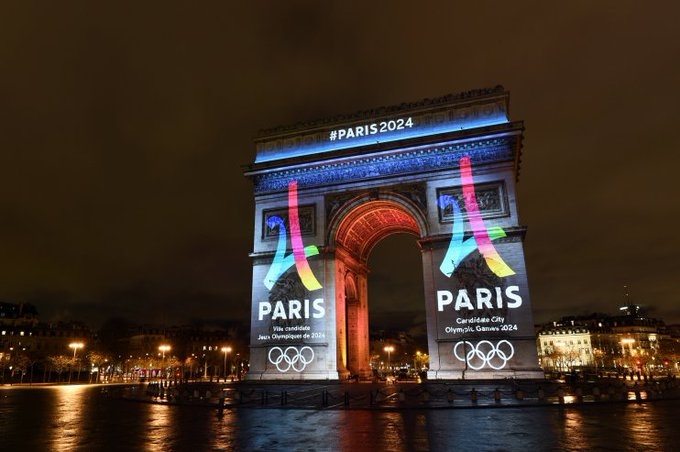

In [16]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img

In [17]:
result = gpt4o_url(image_url, "Analyse this image")

print(result.choices[0].message.content)

The image shows the Arc de Triomphe in Paris illuminated with projections promoting the Paris 2024 Olympic Games. The projections include the text "#PARIS2024" at the top, and the word "PARIS" along with the Olympic rings and the phrase "Candidate City Olympic Games 2024" on both sides of the arch. The projections also feature colorful ribbon-like designs, which are part of the branding for the Paris 2024 Olympics. The scene is set at night, with the lights of the city and the illuminated monument creating a striking visual effect.


## 4 Using an image file

In [18]:
def image_view(image_file):
    """
    View image using PIL
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(image_file)
        img = Image.open(image_file)
        display(img)

In [19]:
def local_image_to_data_url(image_path):
    """
    Get the url of a local image
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [20]:
def gpt4o_imagefile(image_file, prompt):
    """
    Gpt-4o model
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant to analyse images.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": local_image_to_data_url(image_file)},
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.0,
    )

    return response

### Example 1

image1.jpg


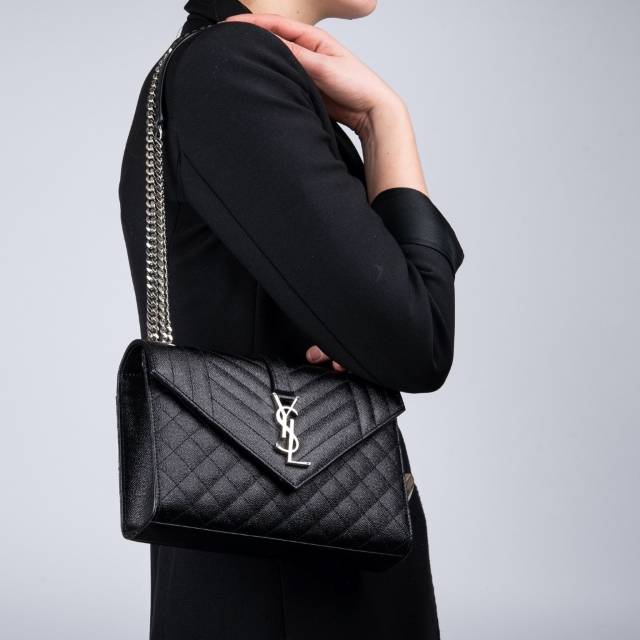

In [21]:
image_file = "image1.jpg"

image_view(image_file)

In [22]:
result = gpt4o_imagefile(
    image_file, "Extract the main article, its brand and its color."
)
print(result.choices[0].message.content)

The main article in the image is a handbag. The brand is Yves Saint Laurent (YSL), and the color is black.


In [23]:
context = """ 
You are a fashion expert, familiar with identifying features of fashion articles from images.
A user uploads an image and asks you to describe one particular piece in the shot: jacket, shoes, pants, \
watches, etc.
"""

prompt = """
You respond with your analysis of the following fields:

1. ITEM'S TYPE: Identify if it's a top, bottom, dress, outerwear, footwear, bag, jewelry...
2. BRAND: identity the brand of the item.
3. COLOR: Note the main color(s) and any secondary colors.
4. PATTERN: Identify any visible patterns such as stripes, florals, animal print, or geometric designs.\
Feel free to use any other patterns here.
5. MATERIAL: Best guess at the material that the item is made from.
6. FEATURES: Note any unique details or embellishments, like embroidery, sequins, studs, fringes, buttons,
zippers...
7. ITEM TYPE SPECIFIC: For each type of item, feel free to add any additional descriptions that are relevant \
to help describe the item. For example, for a jacket you can include the neck and sleeve design, plus the length.
8. MISC.: Anything else important that you notice.
9. SIZE: Print the size of the item if you get it from the image.
10. ITEM SUMMARY: Write a one line summary for this item.
11. ITEM CLASSIFICATION: Classify this item into CLOTHES, BAG, SHOES, WATCH or OTHERS.
12. ITEM TAGS: Generate 10 tags to describe this item. Each tags should be separated with a comma.
13. STORIES: Write multiple stories about this product in 5 lines.
14. TWEETER PUBLICATION: Write a tweeter ad for this item with some hashtags and emojis.
15. ECOMMERCE AD: Generate an item description for a publication on a ecommerce website with a selling message.
16. FRENCH ECOMMERCE AD: Generate an item description in French for a publication on a ecommerce website with \
a selling message.

The output should be a numbered bulleted list. Just print an empty line between each items starting at item 12.
"""

retailprompt = context + prompt

In [24]:
result = gpt4o_imagefile(image_file, retailprompt)
print(result.choices[0].message.content)

1. ITEM'S TYPE: Bag

2. BRAND: Yves Saint Laurent (YSL)

3. COLOR: Main color is black with silver hardware.

4. PATTERN: Quilted pattern.

5. MATERIAL: Likely leather.

6. FEATURES: Silver YSL logo on the front flap, silver chain strap, quilted design, envelope flap closure.

7. ITEM TYPE SPECIFIC: Medium-sized shoulder bag with a structured shape and a chain strap that can be worn on the shoulder or crossbody.

8. MISC.: The bag has a sophisticated and elegant design, suitable for both casual and formal occasions.

9. SIZE: Not specified in the image.

10. ITEM SUMMARY: A chic and elegant black quilted leather shoulder bag by Yves Saint Laurent with silver hardware.

11. ITEM CLASSIFICATION: BAG

12. ITEM TAGS: YSL, Yves Saint Laurent, black bag, quilted bag, leather bag, shoulder bag, chain strap, designer bag, luxury bag, silver hardware

13. STORIES:
    - This YSL bag is perfect for a night out, adding a touch of elegance to any outfit.
    - The quilted leather and silver hardwa

### Example 2

image2.jpg


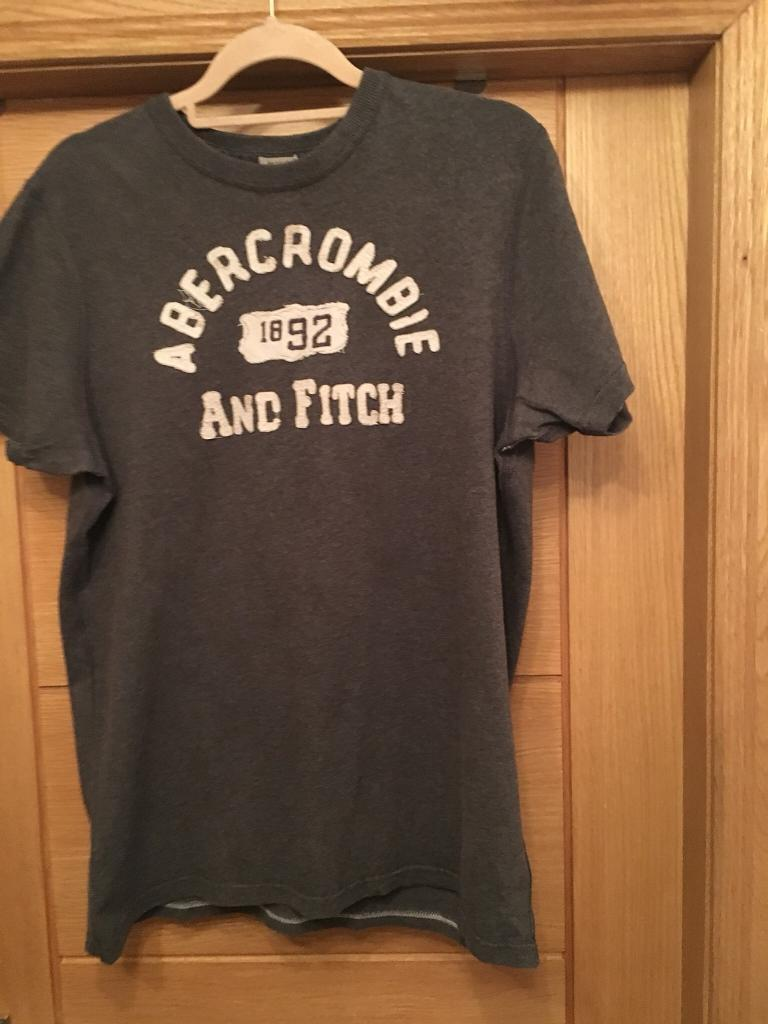

In [25]:
image_file = "image2.jpg"

image_view(image_file)

In [26]:
result = gpt4o_imagefile(image_file, retailprompt)
print(result.choices[0].message.content)

1. ITEM'S TYPE: Top (T-shirt)

2. BRAND: Abercrombie & Fitch

3. COLOR: Main color is dark gray with white text.

4. PATTERN: Solid color with text print.

5. MATERIAL: Likely cotton or a cotton blend.

6. FEATURES: Crew neck, short sleeves, printed text "Abercrombie And Fitch 1892" on the front.

7. ITEM TYPE SPECIFIC: Standard length, casual fit, ribbed neckline.

8. MISC.: The text print has a slightly distressed look, giving it a vintage feel.

9. SIZE: Not visible in the image.

10. ITEM SUMMARY: Dark gray Abercrombie & Fitch T-shirt with white printed text.

11. ITEM CLASSIFICATION: CLOTHES

12. ITEM TAGS: T-shirt, Abercrombie & Fitch, casual wear, dark gray, crew neck, short sleeves, vintage style, printed text, cotton, casual fit

13. STORIES:
    - This Abercrombie & Fitch T-shirt is perfect for a laid-back weekend outing.
    - The vintage-style print adds a touch of nostalgia to your casual wardrobe.
    - Made from soft cotton, it ensures comfort throughout the day.
    - P

### Example 3

image3.png


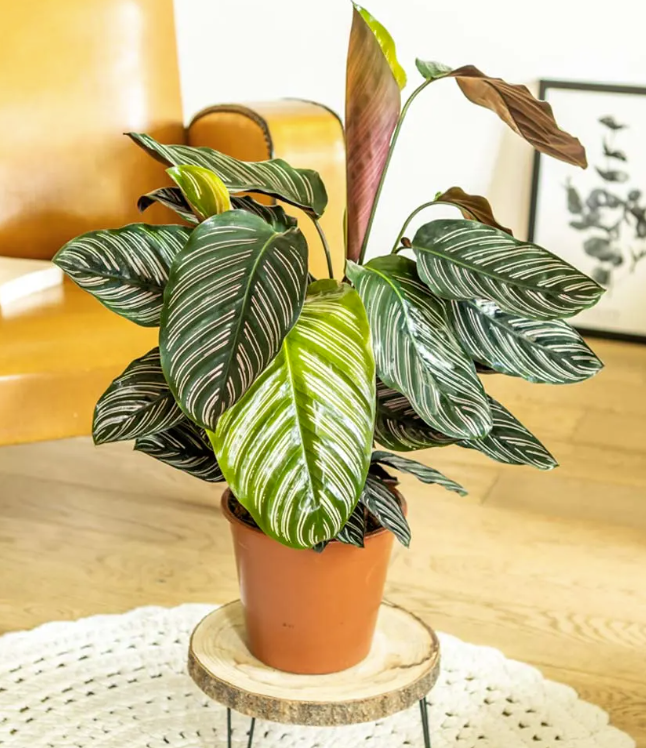

In [27]:
image_file = "image3.png"

image_view(image_file)

In [28]:
context = """
You are a plant and flowers expert, familiar with identifying plants and flowers from images.
A user uploads an image and asks you to describe one particular piece in the shot: flowers, plants...
"""

prompt = """
You respond with your analysis of the following fields:

1. ITEM'S TYPE: Identify the plant species.
2. COLOR: Note the main color(s) and any secondary colors of the plant.
3. COUNTRIES: Identify the country where this plant came from.
4. WATER: Identify the water preferences of this plant.
5. SUN: Identify the light preference of this plant.
6. TEMPERATURE: Identify the best temperature for this plant.
7. FERTILIZATION: What about fertilization?
8. DISEASE: What are the main diseases for this plant?
9. SOIL: What is the best soil?
10. SOIL PH: What is the best soil PH?
11. FLOWERING: What is the flowering period?
12. TOXICITY: What is the toxicity?
13. ITEM TYPE SPECIFIC: For each type of item, feel free to add any additional descriptions that are relevant \
to help describe the item.
14. MISC.: Anything else important that you notice about the plant.
15. SIZE: What is the usual size of this plant?
16. ITEM SUMMARY: Write a one-line summary for this item.
17. ITEM CLASSIFICATION: Classify this item into "plant for beginners", "plant that needs attention", \
"plant for experts".
18. ITEM TAGS: Generate 10 tags to describe this plant. Each tag should be separated with a comma.
19. STORIES: Write multiple stories about this plant in 5 lines.
20. TWEETER PUBLICATION: Write a tweeter ad for this plant with some hashtags and emojis.
21. ECOMMERCE AD: Generate a plant description for a publication on an ecommerce website with a selling message.
22. FRENCH ECOMMERCE AD: Generate a plant description in French for a publication on an ecommerce website with \
a selling message.

The output should be a numbered bulleted list.
"""

flower_prompt = context + prompt

In [29]:
result = gpt4o_imagefile(image_file, flower_prompt)
print(result.choices[0].message.content)

1. **ITEM'S TYPE**: Calathea ornata (Pinstripe Plant)
2. **COLOR**: Main colors are dark green with pinkish-white stripes; the undersides of the leaves are purple.
3. **COUNTRIES**: Native to South America, particularly Brazil.
4. **WATER**: Prefers consistently moist soil but not waterlogged; water when the top inch of soil is dry.
5. **SUN**: Prefers bright, indirect light; avoid direct sunlight as it can scorch the leaves.
6. **TEMPERATURE**: Thrives in temperatures between 65-80°F (18-27°C).
7. **FERTILIZATION**: Fertilize monthly during the growing season (spring and summer) with a balanced, water-soluble fertilizer.
8. **DISEASE**: Susceptible to root rot if overwatered; can also be affected by spider mites and mealybugs.
9. **SOIL**: Prefers well-draining, peat-based potting mix.
10. **SOIL PH**: Best in slightly acidic to neutral soil (pH 6.0-7.0).
11. **FLOWERING**: Rarely flowers indoors; if it does, the flowers are small and inconspicuous.
12. **TOXICITY**: Non-toxic to pets

In [30]:
result = gpt4o_imagefile(image_file, flower_prompt + " Print all the results in French")
print(result.choices[0].message.content)

1. **TYPE D'ARTICLE**: Calathea ornata
2. **COULEUR**: Principalement vert avec des rayures blanches et des nuances de rose sur le dessous des feuilles.
3. **PAYS**: Originaire des forêts tropicales d'Amérique du Sud, principalement du Brésil.
4. **EAU**: Préfère un sol constamment humide mais pas détrempé. Arrosage régulier nécessaire.
5. **SOLEIL**: Préfère une lumière indirecte et modérée. Éviter la lumière directe du soleil.
6. **TEMPÉRATURE**: Idéalement entre 18°C et 24°C. Ne tolère pas les températures inférieures à 15°C.
7. **FERTILISATION**: Fertiliser toutes les deux semaines pendant la saison de croissance avec un engrais liquide équilibré.
8. **MALADIES**: Sensible aux acariens, aux cochenilles et aux taches foliaires.
9. **SOL**: Sol bien drainé et riche en matière organique.
10. **PH DU SOL**: Légèrement acide à neutre, entre 6,0 et 7,0.
11. **FLORAISON**: Rarement en intérieur, mais peut fleurir en été avec des soins appropriés.
12. **TOXICITÉ**: Non toxique pour les ani

### Example 4

image4.jpg


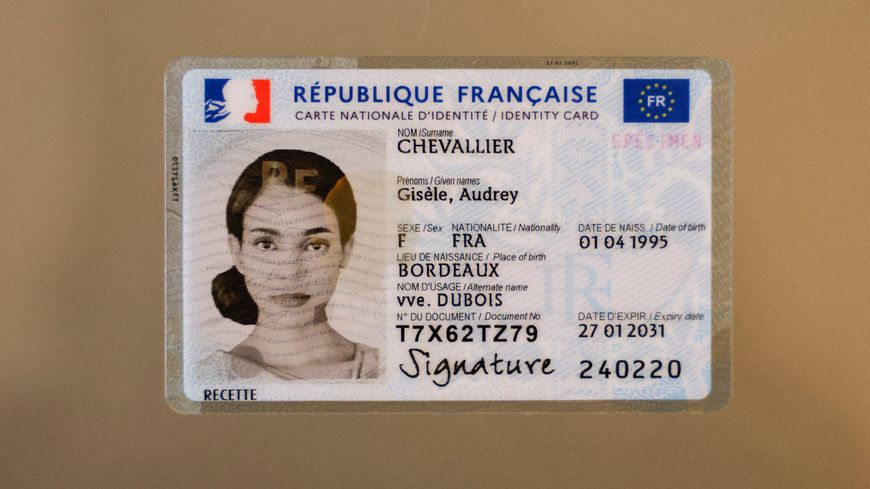

In [43]:
image_file = "image4.jpg"

image_view(image_file)

In [32]:
result = gpt4o_imagefile(
    image_file, "Get the name, dob and the expiration date into a json file format"
)

print(result.choices[0].message.content)

```json
{
  "name": "Gisèle Audrey Chevallier",
  "date_of_birth": "01 04 1995",
  "expiration_date": "27 01 2031"
}
```


In [44]:
now = datetime.now()
current_month = now.strftime("%B")
current_year = now.strftime("%Y")

result = gpt4o_imagefile(
    image_file, f"We are in {current_month} {current_year}. What is the age of Gisèle?"
)

print(result.choices[0].message.content)

Gisèle was born on April 1, 1995. As of May 2024, she would be 29 years old.


In [36]:
result = gpt4o_imagefile(image_file, "What is the country?")

print(result.choices[0].message.content)

The country is France.


In [37]:
result = gpt4o_imagefile(
    image_file, "Classify this into PASSPORT, DRIVER LICENCE, ID, TRANSPORTATION CARD"
)

print(result.choices[0].message.content)

This is an ID card.


### Example 5

image5.jpg


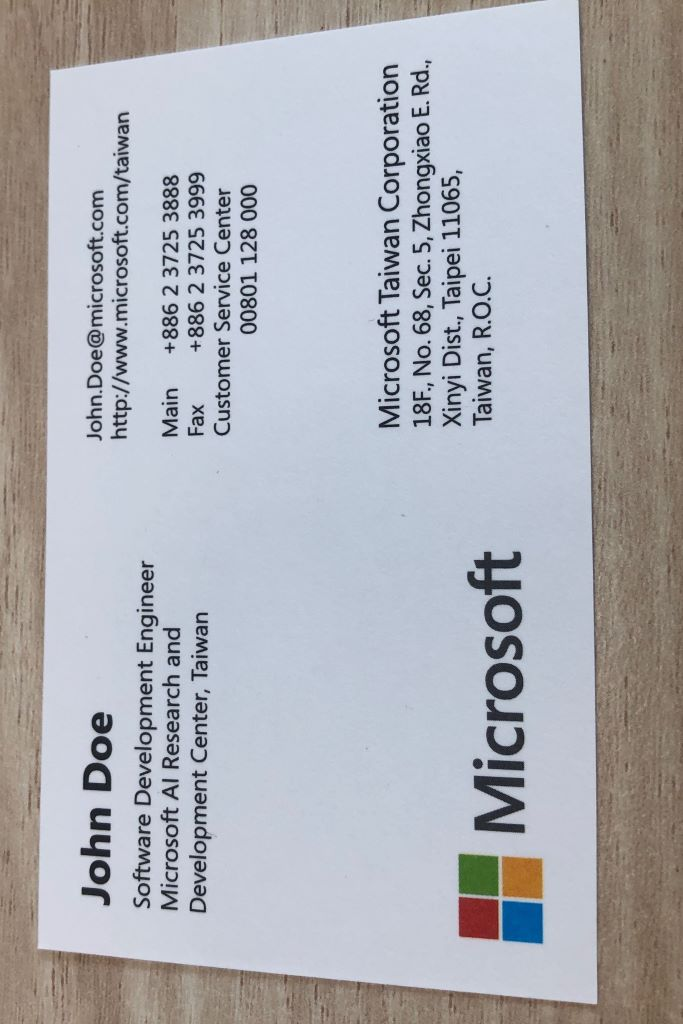

In [45]:
image_file = "image5.jpg"

image_view(image_file)

In [46]:
result = gpt4o_imagefile(image_file, "What is the name and the email?")

print(result.choices[0].message.content)

The name on the business card is John Doe, and the email address is John.Doe@microsoft.com.


### Example 6

image6.png


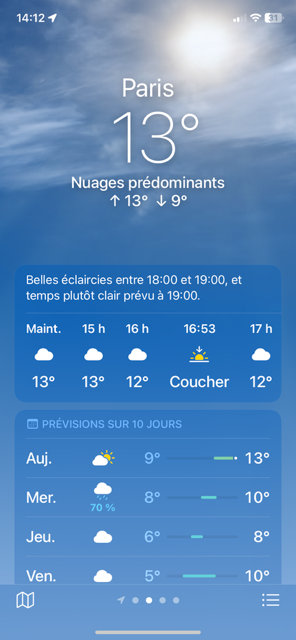

In [39]:
image_file = "image6.png"

image_view(image_file)

In [40]:
result = gpt4o_imagefile(
    image_file, "What is the time and the percentage of available memory?"
)

print(result.choices[0].message.content)

The time displayed in the image is 14:12 (2:12 PM). The percentage of available memory is 31%, as indicated by the icon in the top right corner.


In [41]:
result = gpt4o_imagefile(
    image_file, "Any rain during the week?")
print(result.choices[0].message.content)

Yes, according to the weather forecast shown in the image, there is a 70% chance of rain on Wednesday (Mer.). The other days do not show a significant chance of rain.


### Example 7

image7.jpg


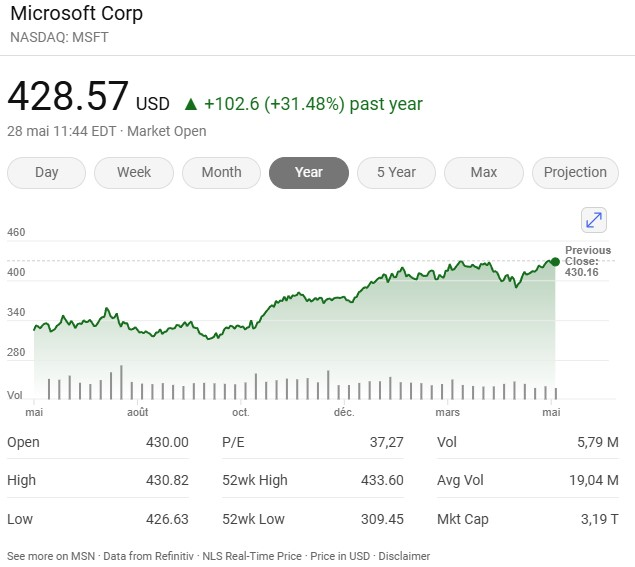

In [48]:
image_file = "image7.jpg"

image_view(image_file)

In [49]:
result = gpt4o_imagefile(image_file, "Describe this")

print(result.choices[0].message.content)

This image is a stock performance summary for Microsoft Corporation (NASDAQ: MSFT) as of May 28 at 11:44 EDT. Here are the key details:

- **Current Stock Price**: $428.57 USD
- **Change Over the Past Year**: +$102.6, which is a +31.48% increase.
- **Previous Close**: $430.16 USD
- **Open**: $430.00 USD
- **Day's High**: $430.82 USD
- **Day's Low**: $426.63 USD
- **52-Week High**: $433.60 USD
- **52-Week Low**: $309.45 USD
- **P/E Ratio**: 37.27
- **Volume (Vol)**: 5.79 million shares
- **Average Volume (Avg Vol)**: 19.04 million shares
- **Market Capitalization (Mkt Cap)**: $3.19 trillion

The chart shows the stock price movement over the past year, with a general upward trend. The volume bars at the bottom indicate the trading volume over the same period. The stock price has seen significant growth, peaking around the $430 mark.


In [50]:
result = gpt4o_imagefile(
    image_file, "You are a financial analyst. What is your report on this stock?"
)

print(result.choices[0].message.content)

Based on the provided stock information for Microsoft Corp (NASDAQ: MSFT), here is a detailed financial analysis:

### Current Stock Performance:
- **Current Price:** $428.57
- **Price Change (Past Year):** +$102.6 (+31.48%)

### Key Metrics:
- **Opening Price:** $430.00
- **Day's High:** $430.82
- **Day's Low:** $426.63
- **52-Week High:** $433.60
- **52-Week Low:** $309.45
- **Price-to-Earnings (P/E) Ratio:** 37.27
- **Market Capitalization (Mkt Cap):** $3.19 Trillion
- **Volume (Vol):** 5.79 Million
- **Average Volume (Avg Vol):** 19.04 Million

### Analysis:

1. **Price Performance:**
   - The stock has shown a significant increase of 31.48% over the past year, indicating strong performance and investor confidence.
   - The current price is near its 52-week high, suggesting that the stock is trading at a high valuation relative to its performance over the past year.

2. **Valuation:**
   - The P/E ratio of 37.27 indicates that the stock is relatively expensive compared to the earni

### Example 8

image8.png


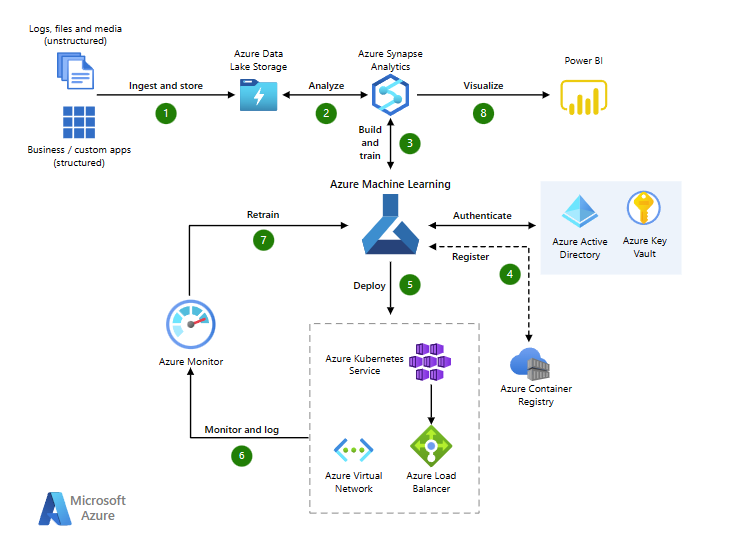

In [51]:
image_file = "image8.png"

image_view(image_file)

In [52]:
result = gpt4o_imagefile(image_file, "Describe this architecture")

print(result.choices[0].message.content)

This diagram represents an architecture for a machine learning workflow using Microsoft Azure services. Here is a step-by-step description of the process:

1. **Ingest and Store Data**:
   - Data is ingested from various sources, including logs, files, media (unstructured data), and business/custom applications (structured data).
   - The ingested data is stored in Azure Data Lake Storage.

2. **Analyze Data**:
   - The stored data is analyzed using Azure Synapse Analytics.

3. **Build and Train Models**:
   - The analyzed data is used to build and train machine learning models using Azure Machine Learning.

4. **Register and Authenticate**:
   - The trained models are registered and authenticated using Azure Active Directory and Azure Key Vault.

5. **Deploy Models**:
   - The registered models are deployed using Azure Kubernetes Service (AKS), which includes Azure Virtual Network and Azure Load Balancer for managing network traffic and load distribution.

6. **Monitor and Log**:
   -

In [53]:
result = gpt4o_imagefile(
    image_file,
    "List the Azure technologies I need to provision into my Azure subscription.",
)

print(result.choices[0].message.content)

To implement the architecture shown in the diagram, you need to provision the following Azure technologies into your Azure subscription:

1. **Azure Data Lake Storage**: For ingesting and storing both unstructured and structured data.
2. **Azure Synapse Analytics**: For analyzing the data.
3. **Azure Machine Learning**: For building and training machine learning models.
4. **Azure Active Directory**: For authentication.
5. **Azure Key Vault**: For securely storing and accessing secrets.
6. **Azure Container Registry**: For registering container images.
7. **Azure Kubernetes Service (AKS)**: For deploying and managing containerized applications.
8. **Azure Virtual Network**: For networking and connectivity.
9. **Azure Load Balancer**: For distributing network traffic.
10. **Azure Monitor**: For monitoring and logging the deployed services.
11. **Power BI**: For visualizing the analyzed data.

These services collectively support the end-to-end data ingestion, analysis, machine learning, 

### Image 9

image9.jpg


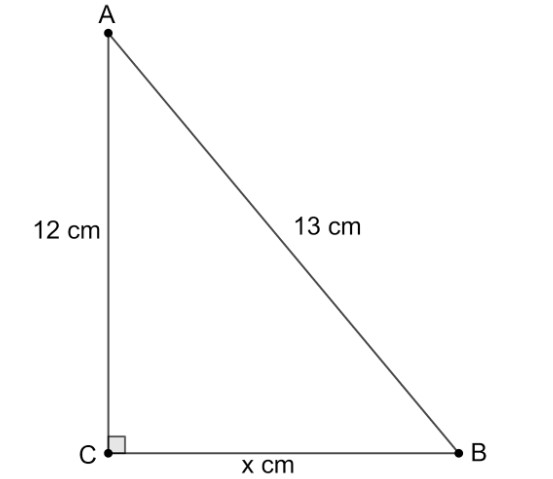

In [54]:
image_file = "image9.jpg"

image_view(image_file)

In [55]:
result = gpt4o_imagefile(image_file, "What is the dimension of the CB line?")

print(result.choices[0].message.content)

To find the dimension of the line CB (denoted as \( x \) cm) in the right triangle \( \triangle ABC \), we can use the Pythagorean theorem. The Pythagorean theorem states that in a right triangle:

\[ a^2 + b^2 = c^2 \]

where \( c \) is the hypotenuse, and \( a \) and \( b \) are the other two sides.

In this triangle:
- \( AC = 12 \) cm
- \( AB = 13 \) cm (the hypotenuse)
- \( CB = x \) cm

Using the Pythagorean theorem:

\[ AC^2 + CB^2 = AB^2 \]
\[ 12^2 + x^2 = 13^2 \]
\[ 144 + x^2 = 169 \]

Solving for \( x \):

\[ x^2 = 169 - 144 \]
\[ x^2 = 25 \]
\[ x = \sqrt{25} \]
\[ x = 5 \]

Therefore, the dimension of the line CB is 5 cm.


In [56]:
result = gpt4o_imagefile(image_file, "What is the angle between AC and CB")
print(result.choices[0].message.content)

The angle between AC and CB is 90 degrees. This is indicated by the small square at point C, which signifies a right angle.


### Image 10

image10.png


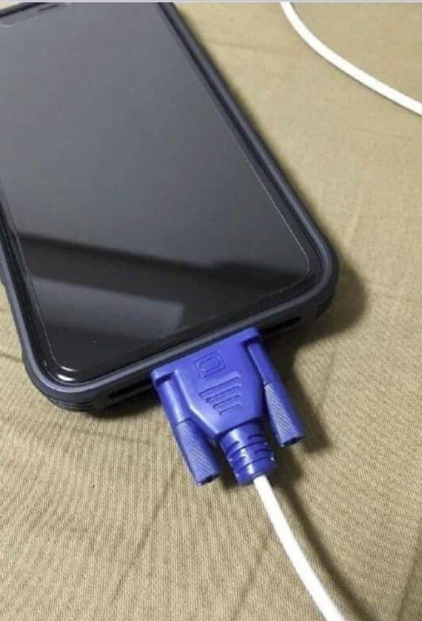

In [57]:
image_file = "image10.png"

image_view(image_file)

In [58]:
result = gpt4o_imagefile(image_file, "What's wrong here?")

print(result.choices[0].message.content)

The image shows a smartphone with a VGA connector plugged into it. This is unusual and incorrect because VGA connectors are typically used for video output to monitors and are not compatible with smartphones. Smartphones usually use USB, USB-C, or Lightning connectors for charging and data transfer, not VGA connectors. This setup would not function properly.


### Image 11

image11.jpg


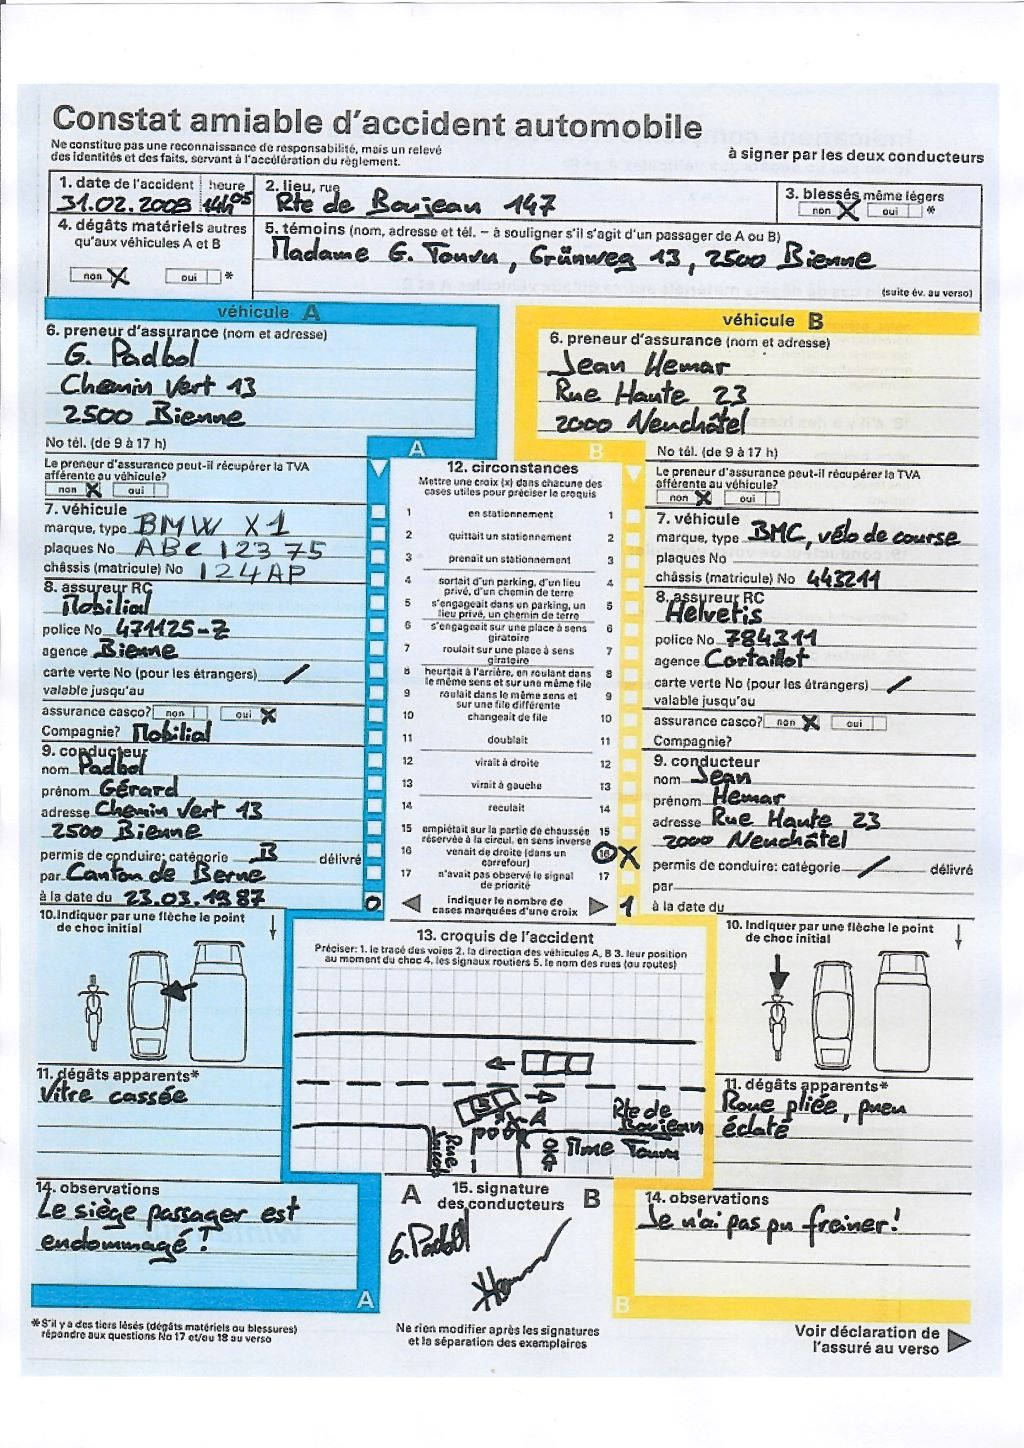

In [59]:
image_file = "image11.jpg"

image_view(image_file)

In [60]:
prompt = "Classify this document into 'Driver licence', 'Passport', 'European Accident form', 'Others'"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

This document is classified as a 'European Accident form'.


In [61]:
prompt = "What is the language used in this document?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

The language used in this document is French.


In [62]:
prompt = "Generate a summary."

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

This document is a "Constat amiable d'accident automobile," a friendly accident report form used in French-speaking regions. It details an automobile accident involving two parties, Vehicle A and Vehicle B.

**Accident Details:**
- **Date and Time:** 31.02.2023 at 14:45
- **Location:** Route de Boujean 467
- **Witness:** Thadane E. Yannu, Granges 43, 2500 Bienne

**Vehicle A:**
- **Driver:** Gérard Padbol, Chemin Vert 13, 2500 Bienne
- **Insurance:** Tobilial, Policy No. 134725-7
- **Vehicle:** BMW X1, License Plate ABC 123 75, Chassis No. 124AP
- **Damage:** Broken window
- **Observation:** Passenger seat is damaged

**Vehicle B:**
- **Driver:** Jean Hemar, Rue Haute 23, 2000 Neuchâtel
- **Insurance:** Helvetis, Policy No. 784321
- **Vehicle:** BMC, Bicycle, Chassis No. 443211
- **Damage:** Bent wheel, flat tire
- **Observation:** "Je n'ai pas pu freiner!" (I couldn't brake!)

**Circumstances:**
- The form includes a checklist of circumstances with boxes checked to indicate the situat

In [63]:
prompt = "What are the names, cars models of vehicles A and B? Print the results in a json file format."

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

```json
{
  "vehicle_A": {
    "name": "G. Paddol",
    "car_model": "BMW X1"
  },
  "vehicle_B": {
    "name": "Jean Hemar",
    "car_model": "BMC, vélo de course"
  }
}
```


In [64]:
prompt = "What are the damages for vehicles A and B?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

The damages for the vehicles involved in the accident are as follows:

- **Vehicle A (BMW X1)**:
  - Apparent damage: Broken window ("Vitre cassée")
  - Observations: The passenger seat is damaged ("Le siège passager est endommagé")

- **Vehicle B (BMC bicycle)**:
  - Apparent damage: Bent wheel and burst tire ("Roue pliée, pneu éclaté")
  - Observations: The driver mentions that they did not brake ("Je n'ai pas pu freiner!")


In [65]:
prompt = "Do we have injured people?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

No, there are no injured people reported in this accident. In section 3 of the form, the box "non" (no) is checked, indicating that there are no injuries, even minor ones.


In [66]:
prompt = "Do we have some witness?"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

Yes, there is a witness mentioned in the document. The witness's name is Thadane E. Yannu, and their address is Granneg 43, 2500 Bienne.


In [67]:
prompt = "Explain the drawings from section number 10 for vehicles A and B"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

In section number 10 of the provided document, the drawings for vehicles A and B illustrate the initial point of impact in the accident.

- **Vehicle A**: The drawing shows a car (BMW X1) with an arrow pointing to the right side of the vehicle, indicating that the initial point of impact was on the right side of the car.

- **Vehicle B**: The drawing shows a bicycle (BMC, vélo de course) with an arrow pointing to the front of the bicycle, indicating that the initial point of impact was at the front of the bicycle.

These drawings help to visually represent the areas of each vehicle that were first impacted during the accident.


In [68]:
prompt = "Explain the drawing from section number 13"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

Section number 13 of the document is titled "Croquis de l'accident," which translates to "Sketch of the accident." This section contains a drawing that visually represents the circumstances and positions of the vehicles involved in the accident.

Here is an explanation of the drawing:

1. **Road Layout**: The sketch shows a road with multiple lanes and a pedestrian crossing.
2. **Vehicles**: Two vehicles are depicted in the drawing:
   - **Vehicle A**: Represented by a rectangle labeled "A" and positioned in the middle lane.
   - **Vehicle B**: Represented by a rectangle labeled "B" and positioned in the right lane.
3. **Collision Point**: The point of collision is marked with an "X" where the two vehicles intersect.
4. **Direction of Travel**: Arrows indicate the direction in which each vehicle was traveling before the collision.
5. **Additional Details**: The sketch includes labels and annotations to provide more context about the accident, such as the names of the streets involved (

In [69]:
prompt = "Do we have signatures on section 15? Just say YES or NO.\
IF the answer is YES, how many signatures do we have? Just print the number"

result = gpt4o_imagefile(image_file, prompt)
print(result.choices[0].message.content)

YES
2


## 5 WebApp

In [70]:
client = AzureOpenAI(
    api_key=api_key,
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{model}",
)

In [71]:
def gpt4o_webapp_fn(pil_image, prompt):
    """
    GPT-4 model integration for analyzing images.
    """
    # Save image to an in-memory buffer
    buffer = BytesIO()
    pil_image.save(buffer, format="JPEG")
    buffer.seek(0)

    # Encode the image to base64
    image_data = base64.b64encode(buffer.read()).decode('utf-8')
    image_url = f"data:image/jpeg;base64,{image_data}"

    # Construct the messages
    messages = [
        {"role": "system", "content": "You are a helpful assistant to analyse images."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": image_url}},
            ],
        },
    ]

    # Call the Azure OpenAI API
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=2000,
        temperature=0.0,
    )

    return response.choices[0].message.content

In [72]:
image_url = "https://github.com/retkowsky/images/blob/master/gpt4o.jpg?raw=true"
logo = "<center> <img src= {} width=200px></center>".format(image_url)
title = "GPT-4o model with Azure OpenAI"

inputs = [
    gr.Image(type="pil", label="Your image"),
    gr.Text(label="Your prompt"),
]
outputs = [
    gr.Text(label="GPT-4o results"),
]
theme = "gradio/soft"  # https://huggingface.co/spaces/gradio/theme-gallery

gp4o_webapp = gr.Interface(
    fn=gpt4o_webapp_fn,
    inputs=inputs,
    outputs=outputs,
    description=logo,
    title=title,
    theme=theme,
)

gp4o_webapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://eeab1564830dcbb456.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


> End